This notebooks shows an example of using a correction curve, based on charge injection data, to perform ADC-TOT cross-calibration on run 300 data. This is just one well-behaving example channel. 

In [1]:
!pip install -r ../requirements.txt

import sys
sys.path.append('../src')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import math

from selectCleanEvents import *

In [2]:
electrons = pd.read_csv('../analysis_files/run_300_aligned.csv')

In [3]:
events = electrons.loc[electrons['layer'] == 6].loc[electrons['strip'] == 4]

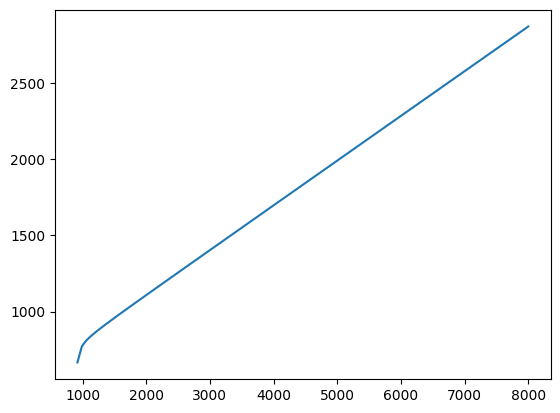

In [7]:
#TOT threshold in units of fC
chargethreshold = 919.7897432289714 #in charge

#The charge-TOT curve that we fitted
def curve(x):
    return 2.92933052e-01*x+5.25930812e+02-4554.6196389/(x-884.5044866)

#Just a plot of this
x = np.linspace(chargethreshold,8000,100)
y = [curve(p) for p in x]
plt.plot(x,y)

#TOT threshold in units of TOT
totthreshold = min([p for p in y if p >= 0])+20

#Here we create the conversion table! 
TOTs = [curve(p) for p in x]
sumADCs = [1.73122781*p + 956.1842243 for p in x] #This is the linear fit we made to the low cap. charge injections 


In [10]:
adcsum = []
totcorrected = []

combined = []

print(totthreshold)

for index, row in events.iterrows():
    #If TOT is below the TOT threshold, use only ADC data
    if row['tot_end1'] < totthreshold:
        adcsum.append(row['adc_sum_end1'])
        combined.append(row['adc_sum_end1'])
    else:
        t = row['tot_end1']
        #Use conversion table to go from TOT to ADC sum
        index = 0
        for i in range(0,len(TOTs)):
            if TOTs[i] >= t:
                index = i
                break
        totcorrected.append(sumADCs[i])
        combined.append(sumADCs[i])

686.2876651499306


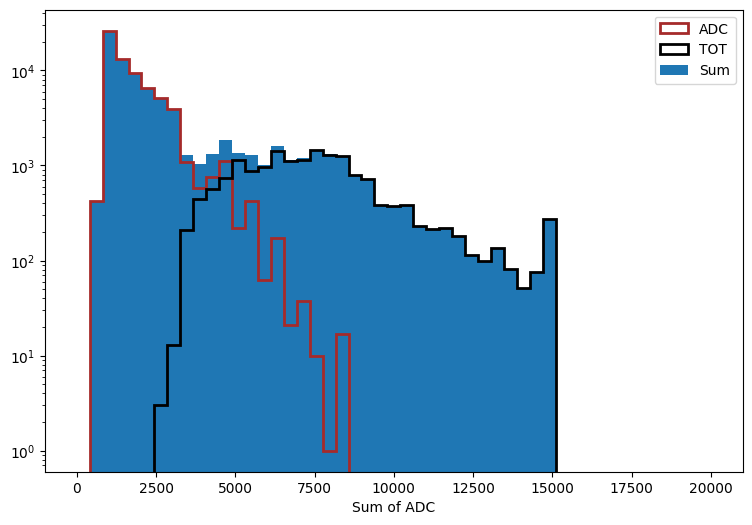

In [23]:
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0,20000,50)

plt.hist(adcsum, bins=bins, histtype="step", color="brown", label="ADC", linewidth=2)

plt.hist(totcorrected, bins=bins, histtype="step", color="black", label="TOT", linewidth=2)

plt.hist(combined, bins=bins, label="Sum")


index = 0
for i in range(0,len(TOTs)):
    if TOTs[i] >= totthreshold:
        index = i
        break
#plt.vlines(sumADCs[i], 0, 10000, color="red", label="TOT Threshold")

plt.legend()
plt.xlabel("Sum of ADC")
plt.yscale("log")